<a href="https://colab.research.google.com/github/Soob00/20251R0136COSE47101/blob/dataset1_decisionTree/notebooks/dataset1_clustered_decisiontrees_all_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

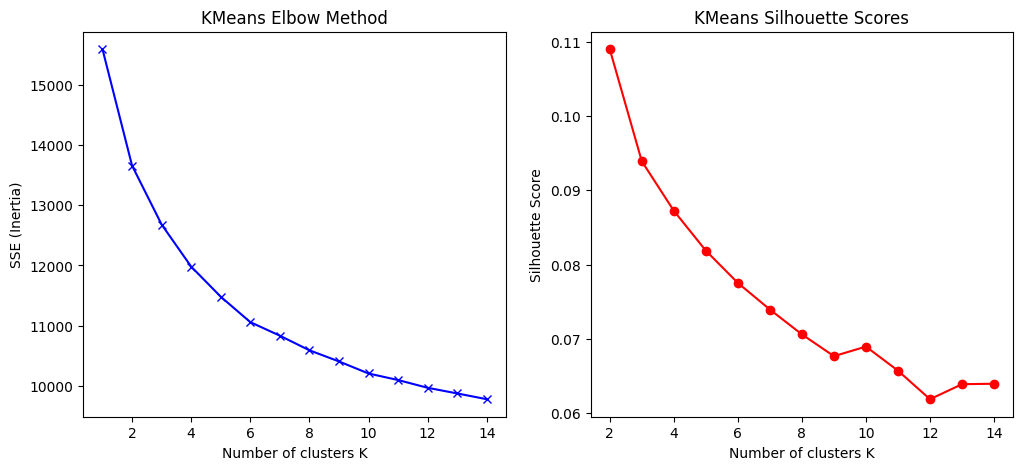

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import pandas as pd
df = pd.read_csv("/content/processed_all_dataset2.csv")
X = df
# 스트레스레벨 값을 0,1,2로 변경 (1,2,3 → 0,1,2)
df['Stress Level'] = df['Stress Level'] - 1



# -------------------------
# 2. KMeans 하이퍼파라미터 튜닝
# -------------------------

sse = []
sil_scores = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    if k > 1:
        labels = kmeans.labels_
        sil_scores.append(silhouette_score(X, labels))
    else:
        sil_scores.append(np.nan)  # k=1은 실루엣 점수 계산 불가

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, sse, 'bx-')
plt.xlabel('Number of clusters K')
plt.ylabel('SSE (Inertia)')
plt.title('KMeans Elbow Method')

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, 'ro-')
plt.xlabel('Number of clusters K')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Scores')
plt.show()



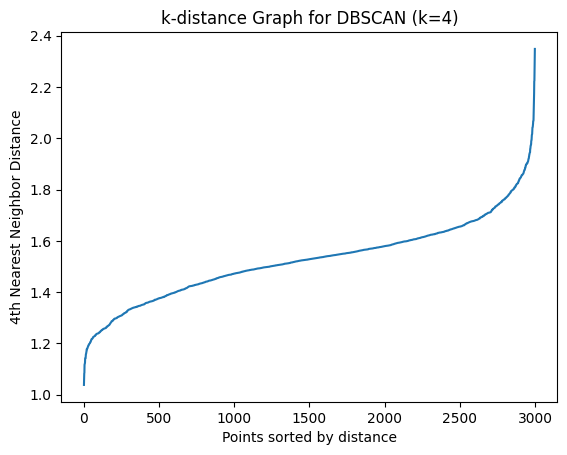

DBSCAN clusters found: 0


In [59]:
# -------------------------
# 3. DBSCAN 하이퍼파라미터 튜닝
# -------------------------

# eps 결정 위해 k-distance 그래프 (min_samples=4 기준)
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances[:, 3])  # 4번째 이웃 거리
plt.plot(distances)
plt.title("k-distance Graph for DBSCAN (k=4)")
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.show()

# 여기서 적당한 eps 범위 확인 후 예시로 eps=0.5 설정
dbscan = DBSCAN(eps=0.5, min_samples=4)
dbscan_labels = dbscan.fit_predict(X)

# 클러스터 개수 (노이즈 제외)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN clusters found: {n_clusters_dbscan}")


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

'''
k=6
'''
# 1. KMeans 클러스터링
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# 클러스터별 샘플 수
print("KMeans 클러스터별 샘플 수:")
print(pd.Series(kmeans_labels).value_counts().sort_index())

# 클러스터별 주요 특징 (평균, 분산)
kmeans_df = pd.DataFrame(X)
kmeans_df['cluster'] = kmeans_labels
print("KMeans 클러스터별 평균 및 분산:")
print(kmeans_df.groupby('cluster').agg(['mean', 'var']))

KMeans 클러스터별 샘플 수:
0    497
1    442
2    527
3    573
4    473
5    488
Name: count, dtype: int64
KMeans 클러스터별 평균 및 분산:
              Age           Exercise Level           Sleep Hours            \
             mean       var           mean       var        mean       var   
cluster                                                                      
0        0.511723  0.089079       2.997988  0.002012    0.321291  0.393295   
1        0.517313  0.083570       2.110860  0.511492   -1.366357  0.304645   
2        0.504249  0.076154       1.747628  0.474210    1.267096  0.314195   
3        0.491843  0.085656       1.167539  0.139714   -0.354843  0.334787   
4        0.495496  0.087605       2.545455  0.248459   -0.381516  0.456386   
5        0.512429  0.090087       1.473361  0.249802    0.328424  0.374049   

        Stress Level           Work Hours per Week            ...  \
                mean       var                mean       var  ...   
cluster                               

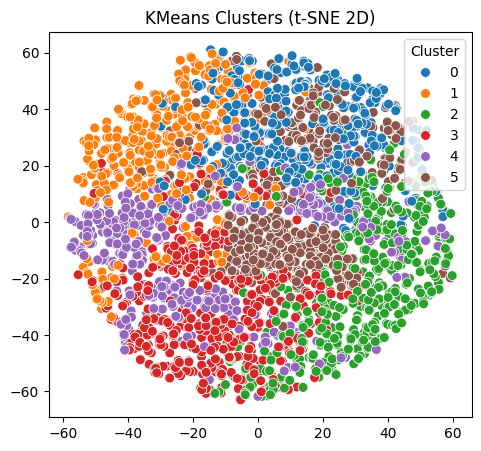

In [61]:
# 4. 클러스터 시각화 (t-SNE)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans_labels, palette='tab10', s=50)
plt.title('KMeans Clusters (t-SNE 2D)')
plt.legend(title='Cluster')


plt.show()


In [62]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering(X, labels, method_name=""):
    """
    클러스터링 결과에 대한 내부 평가 지표를 계산하고 딕셔너리로 반환합니다.

    Parameters:
        X (ndarray): 클러스터링 대상 데이터 (scaling된 것)
        labels (ndarray): 클러스터링 결과 라벨
        method_name (str): 방법 이름 (예: "KMeans", "GMM", "DBSCAN")

    Returns:
        dict: method 이름과 내부 평가 지표들 (Silhouette, Calinski, Davies)
    """
    # 유효한 클러스터 개수 확인
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters <= 1:
        # 클러스터가 1개 이하이면 평가할 수 없음
        return {
            "method": method_name,
            "n_clusters": n_clusters,
            "silhouette": None,
            "calinski": None,
            "davies": None
        }

    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies = davies_bouldin_score(X, labels)

    return {
        "method": method_name,
        "n_clusters": n_clusters,
        "silhouette": silhouette,
        "calinski": calinski,
        "davies": davies
    }


In [63]:
results = []

# KMeans
results.append(evaluate_clustering(X, kmeans_labels, method_name="KMeans"))


# 결과를 데이터프레임으로 보기 좋게 정리
import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df[["method", "n_clusters", "silhouette", "calinski", "davies"]]
results_df


,method,n_clusters,silhouette,calinski,davies
0,KMeans,6,0.07752,245.741253,2.383068


<ipython-input-64-521487c4874b>:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


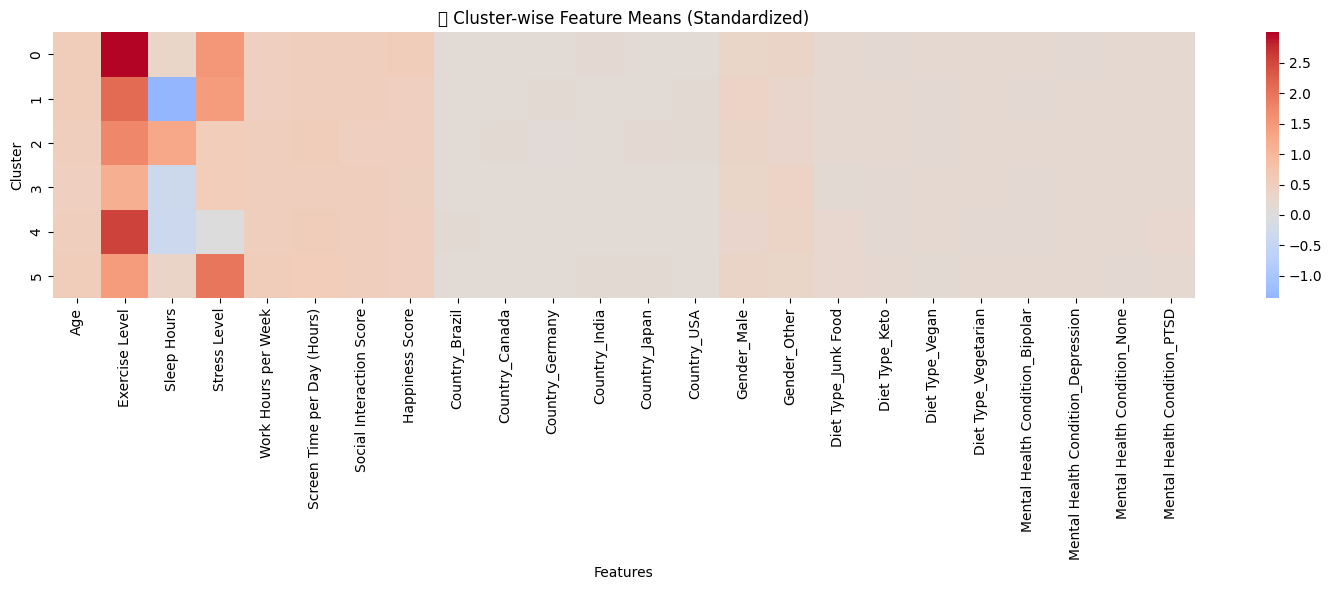

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 클러스터 번호가 담긴 Series 또는 배열을 가진 상태라고 가정 (예: kmeans_labels)
# 클러스터 결과를 데이터프레임에 추가
# feature_names를 정의 (X가 원래 DataFrame일 경우)
feature_names = X.columns

# 클러스터 결과 포함한 새로운 데이터프레임 만들기
clustered_df = pd.DataFrame(X, columns=feature_names)
clustered_df["cluster"] = kmeans_labels
clustered_df = pd.DataFrame(X, columns=feature_names)  # feature_names는 피처 이름 리스트
clustered_df["cluster"] = kmeans_labels  # KMeans 군집 결과

# 클러스터별 평균값 확인
cluster_means = clustered_df.groupby("cluster").mean()

# 히트맵으로 시각화
plt.figure(figsize=(15, 6))
sns.heatmap(cluster_means, cmap="coolwarm", center=0, annot=False)
plt.title("📊 Cluster-wise Feature Means (Standardized)")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


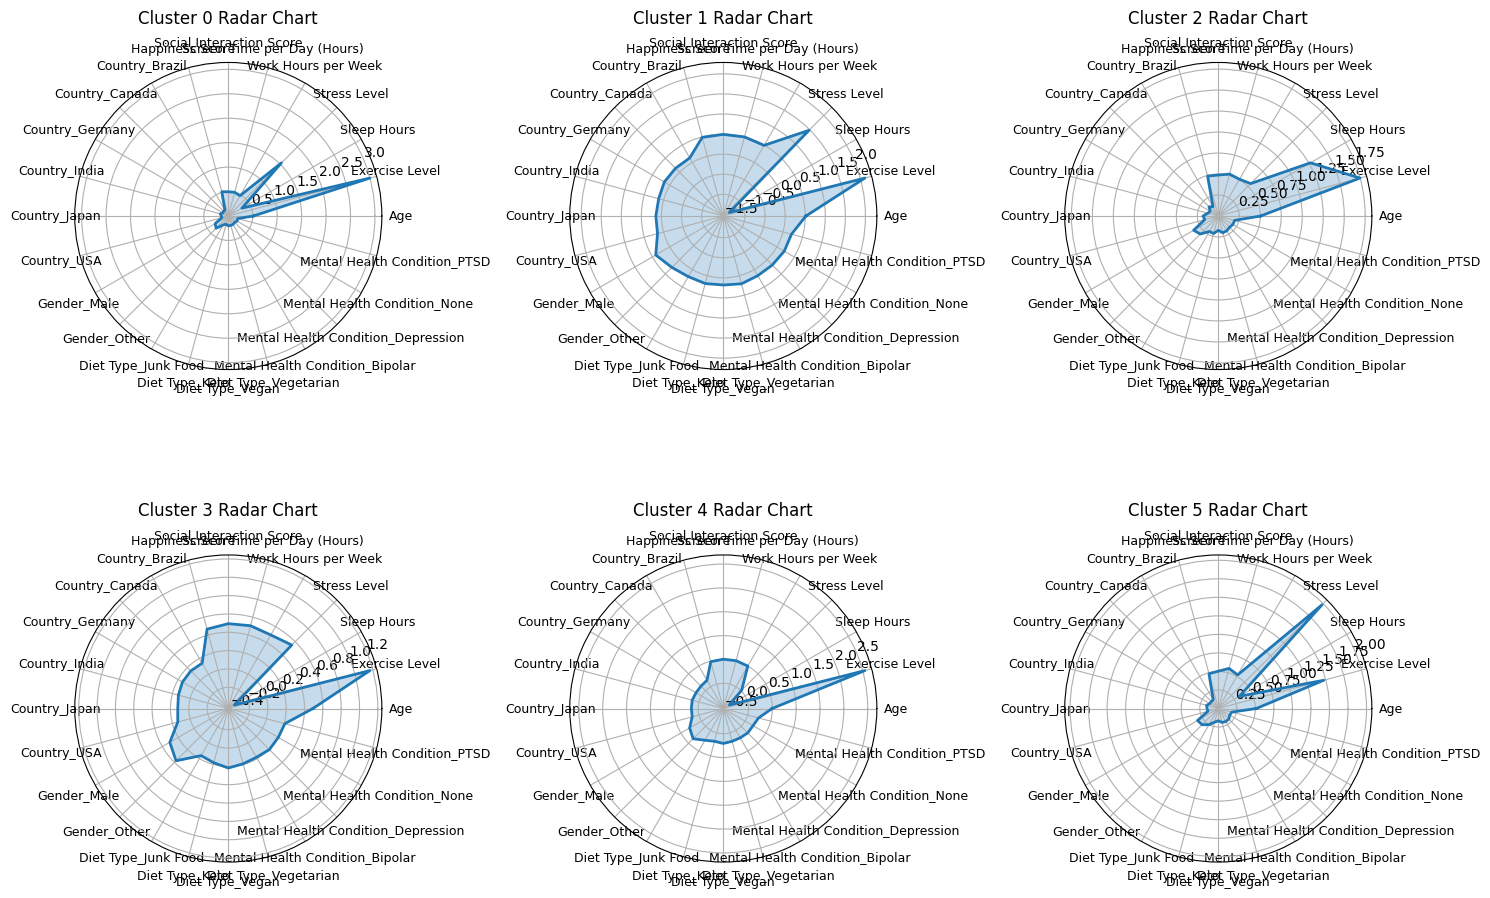

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# 클러스터별 평균 계산
cluster_means = clustered_df.groupby("cluster").mean()

labels = cluster_means.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += [angles[0]]  # 닫기 위해 처음 각도 추가

num_clusters = len(cluster_means)
cols = 3  # 한 행에 3개씩 배치 (원하는 수로 변경 가능)
rows = (num_clusters + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), subplot_kw=dict(polar=True))
axs = axs.flatten()  # 1차원 배열로 만들어서 인덱싱 편하게

for i, (cluster_id, row) in enumerate(cluster_means.iterrows()):
    values = row.values
    values = np.concatenate((values, [values[0]]))  # 닫기 위해 처음값 추가

    ax = axs[i]
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_title(f"Cluster {cluster_id} Radar Chart", y=1.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)

# 남은 subplot은 삭제 (클러스터 수보다 많을 경우)
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [66]:
for cluster_id, data in clustered_df.groupby("cluster"):
    print(f"\nCluster {cluster_id} Summary:")
    print(data.describe().round(3))



Cluster 0 Summary:
           Age  Exercise Level  Sleep Hours  Stress Level  \
count  497.000         497.000      497.000       497.000   
mean     0.512           2.998        0.321         1.537   
std      0.298           0.045        0.627         0.499   
min      0.000           2.000       -0.784         1.000   
25%      0.261           3.000       -0.184         1.000   
50%      0.500           3.000        0.283         2.000   
75%      0.783           3.000        0.683         2.000   
max      1.000           3.000        2.617         2.000   

       Work Hours per Week  Screen Time per Day (Hours)  \
count              497.000                      497.000   
mean                 0.480                        0.502   
std                  0.302                        0.285   
min                  0.000                        0.000   
25%                  0.231                        0.283   
50%                  0.436                        0.483   
75%              

클러스터별 해석 및 시사점
Cluster 0
운동량이 가장 많음(2.99), 행복점수도 가장 높음(0.51).
그러나 스트레스가 매우 높음(2.54).
시사점: 운동이 많아도 스트레스가 높을 수 있음. 운동 외에 스트레스 요인이 많거나, 운동이 스트레스 해소에 충분히 기여하지 못하는 집단일 수 있음.

Cluster 1
수면이 극단적으로 부족(-1.37), 스트레스 높음(2.48), 운동은 중간(2.11).
행복점수는 평균 이하(0.49).
시사점: 수면 부족이 스트레스와 행복 모두에 부정적 영향을 미치는 전형적인 집단.

Cluster 2
수면이 가장 충분(1.27), 스트레스 낮음(1.55), 운동 적음(1.75).
행복점수는 평균(0.49).
시사점: 운동은 적지만 수면이 충분해 스트레스가 낮게 유지되는 집단.

Cluster 3
운동과 수면 모두 부족(1.17, -0.35), 스트레스 낮음(1.55), 행복점수 최저(0.47).
시사점: 운동·수면 모두 부족하면 행복감이 가장 낮아질 수 있음을 시사.

Cluster 4
운동 많음(2.55), 스트레스 가장 낮음(1.02).
수면은 다소 부족(-0.38), 행복점수는 평균(0.49).
시사점: 운동이 스트레스 완화에 효과적임을 보여주는 집단.

Cluster 5
운동 적음(1.47), 스트레스 최고(2.98).
수면은 평균(0.33), 행복점수는 평균(0.49).
시사점: 운동 부족이 스트레스와 연관될 수 있음을 시사.

기타 변수(성별, 식단, 정신건강 상태 등)
성별, 식단, 정신건강 변수는 클러스터별로 큰 차이가 없어 보입니다(대부분 0.17~0.25 수준).
특정 식단(예: Junk Food, Vegetarian 등)이나 정신건강 상태가 클러스터별로 뚜렷하게 구분되지는 않음.

전체 패턴 및 시사점
운동과 스트레스: 운동량이 많으면서 스트레스가 낮은 집단(Cluster 4)이 존재하지만, 운동이 많아도 스트레스가 높은 집단(Cluster 0)도 있음. 즉, 운동만으로 스트레스가 항상 낮아지는 것은 아님.

수면과 스트레스: 수면이 충분한 집단(Cluster 2)에서 스트레스가 낮음. 수면이 부족한 집단(Cluster 1)에서 스트레스가 높음.

행복점수: 대부분의 클러스터에서 0.48~0.51로 큰 차이는 없으나, 운동·수면 모두 부족한 집단(Cluster 3)에서 가장 낮음.

정신건강 변수: 클러스터별로 큰 차이가 없어, 클러스터 구분에 결정적 역할을 하진 않음.

결론
운동과 수면은 스트레스와 밀접한 관련이 있음.

운동이 많고 스트레스가 낮은 집단(Cluster 4), 수면이 충분하고 스트레스가 낮은 집단(Cluster 2)이 존재.

행복점수는 운동과 수면이 모두 부족한 집단(Cluster 3)에서 가장 낮음.

정신건강, 식단 등은 클러스터별로 큰 차이가 없음.

클러스터링을 통해 건강행동(운동, 수면)과 스트레스, 행복의 관계를 입체적으로 파악할 수 있음



In [67]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report



features = clustered_df.columns.drop(['Stress Level', 'cluster'])

models_by_cluster = {}

for cluster_id in sorted(clustered_df['cluster'].unique()):
    cluster_data = clustered_df[clustered_df['cluster'] == cluster_id]
    X_cluster = cluster_data[features]
    y_cluster = cluster_data['Stress Level']

    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

    param_grid = {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }

    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"\n[Cluster {cluster_id}] Best Params: {grid_search.best_params_}")
    print(classification_report(y_test, y_pred))

    models_by_cluster[cluster_id] = best_model



[Cluster 0] Best Params: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 5}
              precision    recall  f1-score   support

           1       0.32      0.27      0.29        45
           2       0.47      0.53      0.50        55

    accuracy                           0.41       100
   macro avg       0.39      0.40      0.39       100
weighted avg       0.40      0.41      0.40       100


[Cluster 1] Best Params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.47      0.55      0.51        38
           2       0.55      0.52      0.53        46

    accuracy                           0.51        89
   macro avg       0.34      0.36      0.35        89
weighted avg       0.48      0.51      0.49        89



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[Cluster 2] Best Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
              precision    recall  f1-score   support

           0       0.58      0.55      0.56        55
           1       0.51      0.60      0.55        43
           2       0.67      0.25      0.36         8

    accuracy                           0.55       106
   macro avg       0.58      0.47      0.49       106
weighted avg       0.56      0.55      0.54       106


[Cluster 3] Best Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.49      0.77      0.60        44
           1       0.78      0.51      0.62        71

    accuracy                           0.61       115
   macro avg       0.64      0.64      0.61       115
weighted avg       0.67      0.61      0.61       115


[Cluster 4] Best Params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 10}
              prec

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



[Cluster 5] Best Params: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10}
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.99      1.00      0.99        97

    accuracy                           0.99        98
   macro avg       0.49      0.50      0.50        98
weighted avg       0.98      0.99      0.98        98



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

features = clustered_df.columns.drop(['Happiness Score', 'cluster'])

models_by_cluster = {}

for cluster_id in sorted(clustered_df['cluster'].unique()):
    cluster_data = clustered_df[clustered_df['cluster'] == cluster_id]
    X_cluster = cluster_data[features]
    y_cluster = cluster_data['Happiness Score']

    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

    param_grid = {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10]
    }

    grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=3, scoring='r2')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"\n[Cluster {cluster_id}] Best Params: {grid_search.best_params_}")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}")

    models_by_cluster[cluster_id] = best_model


[Cluster 0] Best Params: {'max_depth': 3, 'min_samples_split': 10}
R² Score: -0.087
Mean Squared Error: 0.100

[Cluster 1] Best Params: {'max_depth': 3, 'min_samples_split': 10}
R² Score: -0.267
Mean Squared Error: 0.106

[Cluster 2] Best Params: {'max_depth': 3, 'min_samples_split': 10}
R² Score: 0.026
Mean Squared Error: 0.071

[Cluster 3] Best Params: {'max_depth': 3, 'min_samples_split': 10}
R² Score: -0.084
Mean Squared Error: 0.091

[Cluster 4] Best Params: {'max_depth': 3, 'min_samples_split': 2}
R² Score: -0.154
Mean Squared Error: 0.089

[Cluster 5] Best Params: {'max_depth': 3, 'min_samples_split': 10}
R² Score: -0.232
Mean Squared Error: 0.089
